In [5]:
import xnetwork as xn

g = xn.xnet2igraph('citation_net_full.xnet')
print(g.vcount(), g.ecount())

for journal in set(g.vs['journal']):
    print(journal)
    vertex_seq = g.vs.select(journal_eq=journal)

    subg  = g.subgraph(vertex_seq)
    xn.igraph2xnet(subg, 'citation_net_%s.xnet' % journal)


268582 1115829

langmuir
nat. mater.
acs nano
nano lett.
j. mater. chem.
acs appl. mater. interfaces
nat. nanotechnol.
j. mater. chem. a
j. mater. chem. c


In [6]:
import glob
files = glob.glob('citation_net_*.xnet')
print(files)

for file in files:
    g = xn.xnet2igraph(file)
    text = []
    for v in g.vs:
        text.append(v['title'] + '\n' + v['abstract'])
    g.vs['text'] = text
    xn.igraph2xnet(g, file.replace('.xnet', '_text.xnet'))

['citation_net_.xnet', 'citation_net_acs appl. mater. interfaces.xnet', 'citation_net_acs nano.xnet', 'citation_net_full.xnet', 'citation_net_j. mater. chem. a.xnet', 'citation_net_j. mater. chem. c.xnet', 'citation_net_j. mater. chem..xnet', 'citation_net_langmuir.xnet', 'citation_net_nano lett..xnet', 'citation_net_nat. mater..xnet', 'citation_net_nat. nanotechnol..xnet']


In [1]:
import WOS
from pathlib import Path
from functools import partial
from multiprocessing import Pool
from collections import defaultdict

chu_journal = 'ACS Appl. Mater. Interfaces'

journals = [chu_journal, 'ACS Nano', 'Nano Lett.', 'Nat. Nanotechnol.', 
            'Nat. Mater.', 'Langmuir', "J. Mater. Chem. C", "J. Mater. Chem. A", 
            "J. Mater. Chem.", 'ADV MAT RES', 'ADV FUNCT MAT SENS']

dataPath = Path("/mnt/e/WoS/")
WOSDataPath = dataPath / "Data/WoSAggregatedData2020_ALL.bgz"

In [ ]:
journals_set

In [8]:
# filtering
import glob
import xnetwork as xnet
import numpy as np

from igraph import *
from scipy import integrate

# source: https://github.com/aekpalakorn/python-backbone-network/blob/master/backbone.py
def disparity_filter(g):
	total_vtx = g.vcount()
	g.es['alpha_ij'] = 1

	for v in range(total_vtx):
		edges = g.incident(v)

		k = len(edges)
		if k > 1:
			sum_w = sum([g.es[e]['weight'] for e in edges])
			for e in edges:
				w = g.es[e]['weight']
				p_ij = w/sum_w
				alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
				g.es[e]['alpha_ij'] = min(alpha_ij,g.es[e]['alpha_ij'])

def alpha_cut(alpha,g):
	g_copy = g.copy()
	to_delete = g_copy.es.select(alpha_ij_ge=alpha)
	g_copy.delete_edges(to_delete)
	return g_copy

def get_largest_component_size(g):
	components = g.components()
	giant = components.giant()
	return giant.vcount()

def get_best_cut(net,preserve_percent,a_min,a_max):

		error = 0.015
		largest_size = get_largest_component_size(net)

		min_erro = 1000
		a_min_erro = 0.0

		def get_current_percent(a):
			nonlocal min_erro, a_min_erro, a_min, a_max
			cuted_net = alpha_cut(a,net)
		# print('number of edges',cuted_net.ecount())

			preserved_size = get_largest_component_size(cuted_net)
		# print('preserved size',preserved_size)

			current_percent = preserved_size/largest_size

			if min_erro > abs(current_percent-preserve_percent):
				min_erro = abs(current_percent-preserve_percent)
				a_min_erro = a

			return cuted_net,current_percent,a

		i = 0

		a_min_perc = get_largest_component_size(alpha_cut(a_min,net))/largest_size
		a_max_perc = get_largest_component_size(alpha_cut(a_max,net))/largest_size

		a = 0.0

		while True:
			if i > 100:
				cuted_net = alpha_cut(a_min_erro,net)

				print('error infinity loop')
				print('alpha %.2f; preserved %.2f' % (a_min_erro,min_erro+preserve_percent))
				print()
				return cuted_net

			i += 1
				
			a = (a_min+a_max)/2

			cuted_net,current_percent,a = get_current_percent(a)
			current_erro = current_percent-preserve_percent
			
			if abs(current_erro) < error:
				print('total iterations to find the graph',i)
				print('alpha %.2f; preserved %.2f' % (a,current_percent))
				print()

				return cuted_net

			if (a_min_perc-preserve_percent)*(current_percent-preserve_percent) > 0:
				a_min = a
				a_min_perc = current_percent
			else:
				a_max = a
				a_max_perc = current_percent

def apply_backbone(net,a_min,a_max,preserve=0.8):
	disparity_filter(net)
	best = get_best_cut(net,preserve,a_min,a_max)
	return best

In [15]:
files = glob.glob('subset_chu/bardo_cit_*_title_Comm.xnet')
print(files)
preserve = 0.9
a_min = 0.0001
a_max = 1
for file in files:
    net = xnet.xnet2igraph(file).clusters(mode='weak').giant()
    xnet.igraph2xnet(net, file.replace('.xnet', '_giant.xnet'))

['subset_chu/bardo_cit_net_acs appl. mater. interfaces_title_Comm.xnet', 'subset_chu/bardo_cit_net_acs nano_title_Comm.xnet', 'subset_chu/bardo_cit_net_j. mater. chem. a_title_Comm.xnet', 'subset_chu/bardo_cit_net_j. mater. chem. c_title_Comm.xnet', 'subset_chu/bardo_cit_net_j. mater. chem._title_Comm.xnet', 'subset_chu/bardo_cit_net_langmuir_title_Comm.xnet', 'subset_chu/bardo_cit_net_nano lett._title_Comm.xnet', 'subset_chu/bardo_cit_net_nat. mater._title_Comm.xnet', 'subset_chu/bardo_cit_net_nat. nanotechnol._title_Comm.xnet']
29824
subset_chu/bardo_cit_net_acs appl. mater. interfaces_title_Comm.xnet 29824 69491
13281
subset_chu/bardo_cit_net_acs nano_title_Comm.xnet 13281 39284
17671
subset_chu/bardo_cit_net_j. mater. chem. a_title_Comm.xnet 17671 52454
8034
subset_chu/bardo_cit_net_j. mater. chem. c_title_Comm.xnet 8034 17907
12398
subset_chu/bardo_cit_net_j. mater. chem._title_Comm.xnet 12398 25427
43566
subset_chu/bardo_cit_net_langmuir_title_Comm.xnet 43566 202239
15094
subset_

In [18]:
old_lang = xnet.xnet2igraph('cit_langmuir_Comm(1).xnet')

In [24]:
print(files[5])
new_lang = xnet.xnet2igraph(files[5])

subset_chu/bardo_cit_net_langmuir_title_Comm.xnet


In [25]:
print(old_lang.vcount(), old_lang.ecount())

37318 152715


In [26]:
print(new_lang.vcount(), new_lang.ecount())

43566 202239


In [27]:
old_lang.vs.attributes()

['name',
 'Cluster Index',
 'Cluster Name',
 'abstract',
 'journal',
 'refs',
 'text',
 'title',
 'wos_id',
 'year']

In [28]:
new_lang.vs.attributes()

['name',
 'Cluster Index',
 'Cluster Name',
 'abstract',
 'journal',
 'refs',
 'text',
 'title',
 'wos_id',
 'year']

In [33]:
len(set(new_lang.vs['year']))

36

In [34]:
len(set(old_lang.vs['year']))

36

In [35]:
len(set(new_lang.vs['name']))

43552

In [67]:
missing = set(new_lang.vs['title']) - set(old_lang.vs['title'])

In [73]:
vs = new_lang.vs.select(title_in=missing)

In [ ]:
for v in vs:
    print(v)
    print()

In [37]:
import matplotlib.pyplot as plt

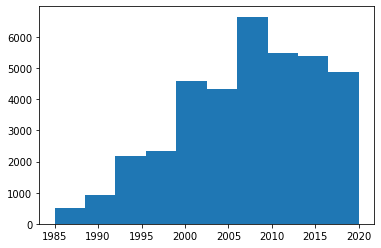

In [38]:
plt.hist(old_lang.vs['year'])
plt.show()

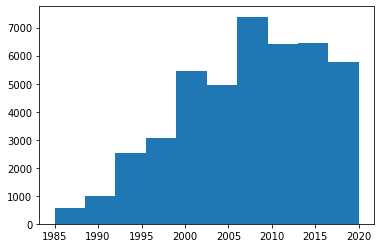

In [39]:
plt.hist(new_lang.vs['year'])
plt.show()

In [ ]:
o que é esse citation_net_full? diferença pra outra


In [64]:
cit_bla = xnet.xnet2igraph('data/citation_net.xnet')

In [58]:
cit_bla.vcount()

98666

In [61]:
cit_bla.vcount()

120475

In [63]:
len(cit_bla.vs.select(journal_eq = 'langmuir'))

40865

In [65]:
cit_bla.vcount()

120475

In [66]:
cit_bla.vs.attributes()

['name', 'abstract', 'journal', 'refs', 'year']

In [75]:
valid_journals = glob.glob("/mnt/e/WoS/ACS/*.xnet")
valid_journals = [file[15:-19].lower() for file in valid_journals]

In [76]:
valid_journals

['acs applied materials & interfaces',
 'acs nano',
 'advances functional materials',
 'advances materials',
 'jacs',
 'journal of materials chemistry',
 'langmuir',
 'nano letters',
 'nature materials',
 'nature nanotechnology']

In [ ]:
reader = WOS.DatabaseReader(WOSDataPath)
pool = Pool(16)    
valid_articles = defaultdict(lambda:[])
c = 0
journals_set = set()
while True:
    articles = reader.readNextArticles(300)
    c += 1
    if(not articles): 
        break
    for article in articles:
        journals = article['titles']['title']
        for j in journals:
            if j['_type'] == 'source':
                b = len(journals_set)
                journals_set.add(j['_VALUE'])
                a = len(journals_set)
                if b != a:
                    print(j['_VALUE'])
                break
reader.close()   

FISHERIES RESEARCH
CLINICAL RADIOLOGY
ACTA TROPICA
JOURNAL OF NUCLEAR MEDICINE
JOURNAL OF TROPICAL PEDIATRICS
CANADIAN JOURNAL OF PLANT SCIENCE
DIURETICS IV : CHEMISTRY, PHARMACOLOGY AND CLINICAL APPLICATIONS
JOURNAL OF IMMUNOLOGY
GLOBAL CHANGE AND SPACE OBSERVATIONS
ZHURNAL OBSHCHEI BIOLOGII
TRANSPLANTATION PROCEEDINGS
HISTORY OF POLITICAL ECONOMY
ENVIRONMENTAL MANAGEMENT : GEO-WATER AND ENGINEERING ASPECTS
PSYCHOSOMATICS
MICROSCOPY RESEARCH AND TECHNIQUE
INFECTION CONTROL AND HOSPITAL EPIDEMIOLOGY
EMBO JOURNAL
LIVESTOCK ENVIRONMENT IV
IEE PROCEEDINGS-A-SCIENCE MEASUREMENT AND TECHNOLOGY
IEEE TRANSACTIONS ON COMPUTERS
MODELLING AND PERFORMANCE EVALUATION OF ATM TECHNOLOGY
AUSTRALIAN JOURNAL OF POLITICS AND HISTORY
PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA
INTERNATIONAL ORTHOPAEDICS
ANNALS OF THE NEW YORK ACADEMY OF SCIENCES
AMERICAN JOURNAL OF ROENTGENOLOGY
PHYSICS OF FLUIDS A-FLUID DYNAMICS
NEW STATESMAN & SOCIETY
ENVIRONMENTAL TOXICOLOGY AND CHE

Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-80:
Traceback (most recent call last):
Process ForkPoolWorker-66:
Process ForkPoolWorker-74:
Process ForkPoolWorker-77:
Process ForkPoolWorker-78:
Process ForkPoolWorker-79:
Process ForkPoolWorker-73:
Process ForkPoolWorker-68:
Process ForkPoolWorker-65:
Process ForkPoolWorker-67:
Process ForkPoolWorker-75:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/acmbrito/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/acmbrito/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
